In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import math
import sys

In [3]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [4]:
import scipy.io as spio
mat = spio.loadmat('forShaul.mat', squeeze_me = True)
simple_r2 = spio.loadmat('simple_r2.mat', squeeze_me = True)

In [18]:
r2 = simple_r2['simple_r2']
r2.shape

(34241,)

In [25]:
for i,k in enumerate(mat.keys()):
    if i > 2: print(k, mat[k].shape)
    else: print(k, mat[k])


__header__ b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jan 18 19:36:47 2023'
__version__ 1.0
__globals__ []
ALM_deep_layers (7084,)
ALM_lateral (14627,)
ALM_medial (19614,)
ALM_superficial_layers (487,)
AP (34241,)
DV (34241,)
ML (34241,)
annotation (34241,)
coord (34241, 3)
fr (34241,)
id (34241,)
midbrain_reticular_nucleus (1272,)
midbrain_substantia_nigra (303,)
pedunculopontine_nucleus (20,)
r2 ()
striatum_dorsal_area (4145,)
striatum_dorsal_lateral_area (2987,)
striatum_dorsal_medial_area (1158,)
striatum_ventral_area (673,)
superior_colliculus_intermediate_and_deep_layers (1433,)
superior_colliculus_superficial_layers (73,)


In [65]:
for ann in mat['annotation']:

    if '5/6' in ann:
        print(ann)

In [8]:
from scipy import stats

In [9]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [10]:
coords = mat['coord']

In [11]:
thalamus_mat = spio.loadmat('thalamus_subregions.mat', squeeze_me = True)

In [12]:
thalamus_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'AN', 'AP', 'CN', 'DV', 'MD', 'MGN', 'ML', 'PC', 'PF', 'PO', 'PVN', 'RT', 'SMN', 'VAL', 'VM', 'VPN', 'annotation', 'coord', 'fr', 'id', 'r2'])

In [13]:
subregion_list = ['AN', 'CN', 'MD', 'MGN', 'PC', 'PF', 'PO', 'PVN', 'RT', 'SMN', 'VAL', 'VM', 'VPN']

In [15]:
for k,v in thalamus_mat.items():
    if k in subregion_list:
        print(k)
        print(v.shape)

AN
(197,)
CN
(382,)
MD
(1709,)
MGN
(126,)
PC
(400,)
PF
(169,)
PO
(901,)
PVN
(32,)
RT
(76,)
SMN
(154,)
VAL
(667,)
VM
(328,)
VPN
(821,)


In [16]:
thalamus_mat['AN'][:10]

array([8087, 8093, 8096, 8097, 8098, 8099, 8100, 8101, 8102, 8103],
      dtype=uint16)

In [14]:
use_subregion_list = list()
for idx, sr in enumerate(subregion_list):
    print('Number of neurons in {} is {}'.format(sr, mat['coord'][thalamus_mat[sr]].shape[0]))
    if mat['coord'][thalamus_mat[sr]].shape[0] > 200:
        use_subregion_list.append(sr)
        print('   Added {}'.format(sr))

Number of neurons in AN is 197
Number of neurons in CN is 382
   Added CN
Number of neurons in MD is 1709
   Added MD
Number of neurons in MGN is 126
Number of neurons in PC is 400
   Added PC
Number of neurons in PF is 169
Number of neurons in PO is 901
   Added PO
Number of neurons in PVN is 32
Number of neurons in RT is 76
Number of neurons in SMN is 154
Number of neurons in VAL is 667
   Added VAL
Number of neurons in VM is 328
   Added VM
Number of neurons in VPN is 821
   Added VPN


In [15]:
use_subregion_list

['CN', 'MD', 'PC', 'PO', 'VAL', 'VM', 'VPN']

In [16]:
#Coronal slice:
#Y is DV
#X is ML

I need to reorganize the lists of the two subregion groups as indices so I can draw colors and stats directly from them and make them consistent across all plots

In [17]:
#thalamus_group_one_list should be: ['CN', 'PC', 'VM', 'VPN']

In [18]:
#thalamus_group_two_list should be: ['MD', 'PO', 'VAL']

In [19]:
thalamus_group_one_list_as_index = list([0,2,5,6])
thalamus_group_two_list_as_index = list([1,3,4])

In [20]:
thalamus_group_one_list = list()
for ii in thalamus_group_one_list_as_index:
    thalamus_group_one_list.append(use_subregion_list[ii])

thalamus_group_two_list = list()
for ii in thalamus_group_two_list_as_index:
    thalamus_group_two_list.append(use_subregion_list[ii])

In [21]:
for ii in thalamus_group_one_list_as_index:
    print(use_subregion_list[ii])

CN
PC
VM
VPN


In [22]:
for ii in thalamus_group_two_list_as_index:
    print(use_subregion_list[ii])

MD
PO
VAL


In [23]:
import ccf_analysis_utils

In [24]:
r2_mask_thresh = 0

In [25]:
#ax.set_xlabel('ML (right-left)')
#ax.set_ylabel('DV (up-down)')
#ax.set_zlabel('AP (front-back)')

In [24]:
from PIL import Image

In [25]:
coronal_slices_allen_file  = '/Users/shauld/Downloads/AllenRefVolCoronal_10_ds222.tif'

In [26]:
def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
        #rgb_img = img.convert('RGB')
        #images.append(np.array(rgb_img))
    return np.array(images)

In [27]:
coronal_slices_array = read_tiff(coronal_slices_allen_file)

In [26]:
# Global offset due to Susu's zeroizing of axes
global_offset_vec = np.array([3000,-2000,5400])

In [27]:
image_plot_DV_start = 100
image_plot_DV_length = 200
image_plot_ML_mid = 285
image_plot_ML_halg_length = 150

In [28]:
coords_offset = np.zeros(coords.shape)
mapped_coords = (coords+global_offset_vec)/20

In [29]:
clim_vals = (0,0.125)

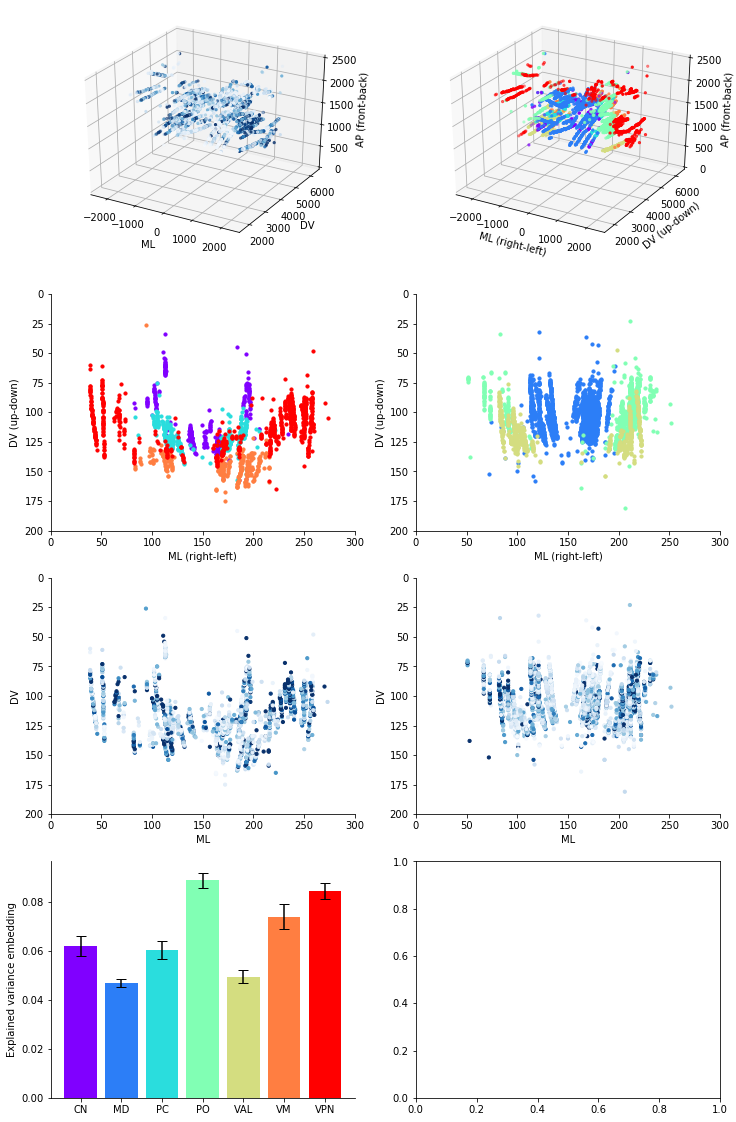

In [30]:
f = plt.figure(figsize=(12,20))
a = f.add_subplot(4,2,1, projection='3d')
three_d_flag = True

plot_dict = dict()
plot_dict['xlim'] = (-2500, 2500)
plot_dict['ylim'] = (1500,6500)
plot_dict['zlim'] = (0,2500)
plot_dict['axis_zero_label'] = 'ML'
plot_dict['axis_one_label'] = 'DV'
plot_dict['axis_two_label'] = 'AP'

clim_vals = (0,0.15)
s = ccf_analysis_utils.add_color_map_plot(a, use_subregion_list, thalamus_mat, r2, coords, \
                       r2_mask_thresh, clim_vals, three_d_flag, plot_dict)
aa = f.add_subplot(4,2,2, projection='3d')

cc = ccf_analysis_utils.add_rainbow_plot(aa, use_subregion_list, thalamus_mat, r2, coords, \
                       r2_mask_thresh, three_d_flag, plot_dict)

thalamus_group_one_color_list = list()
for idx in thalamus_group_one_list_as_index:
    thalamus_group_one_color_list.append(cc[idx])

thalamus_group_two_color_list = list()
for idx in thalamus_group_two_list_as_index:
    thalamus_group_two_color_list.append(cc[idx]) 
    
ax_zero = f.add_subplot(4,2,3)
three_d_flag = False
#ccf_analysis_utils.add_solid_color_plot(ax_zero, thalamus_group_one_list, thalamus_mat, r2, \
#                     coords, r2_mask_thresh, thalamus_group_one_color_list, three_d_flag)
#ax_zero.imshow(coronal_slices_array[345,100:300,(285-150):(285+150)],cmap='gray')
ccf_analysis_utils.add_solid_color_plot(ax_zero, thalamus_group_one_list, thalamus_mat, r2, \
                     mapped_coords[:,0:2], r2_mask_thresh, \
                        thalamus_group_one_color_list, three_d_flag)
ax_zero.set_xlim(0,300)
ax_zero.set_ylim(200,0)

ax_one = f.add_subplot(4,2,4)

#ccf_analysis_utils.add_solid_color_plot(ax_one, thalamus_group_two_list, thalamus_mat, r2, \
#                   coords, r2_mask_thresh, thalamus_group_two_color_list, three_d_flag)
#ax_one.imshow(coronal_slices_array[330,100:300,(285-150):(285+150)],cmap='gray')
ccf_analysis_utils.add_solid_color_plot(ax_one, thalamus_group_two_list, thalamus_mat, r2, \
                     mapped_coords[:,0:2], r2_mask_thresh, \
                        thalamus_group_two_color_list, three_d_flag)
ax_one.set_xlim(0,300)
ax_one.set_ylim(200,0)

ax_zero = f.add_subplot(4,2,5)
#ccf_analysis_utils.add_color_map_plot(ax_zero, thalamus_group_one_list, thalamus_mat, r2, \
#                     coords, r2_mask_thresh, clim_vals, three_d_flag, plot_dict)
#ax_zero.imshow(coronal_slices_array[345,100:300,(285-150):(285+150)],cmap='gray')
ccf_analysis_utils.add_color_map_plot(ax_zero, thalamus_group_one_list, thalamus_mat, r2, \
                     mapped_coords[:,0:2], r2_mask_thresh, clim_vals, three_d_flag, plot_dict)
ax_zero.set_xlim(0,300)
ax_zero.set_ylim(200,0)

ax_one = f.add_subplot(4,2,6)
#ccf_analysis_utils.add_color_map_plot(ax_one, thalamus_group_two_list, thalamus_mat, r2, \
#                     coords, r2_mask_thresh, clim_vals, three_d_flag, plot_dict)
#ax_one.imshow(coronal_slices_array[330,100:300,(285-150):(285+150)],cmap='gray')
ccf_analysis_utils.add_color_map_plot(ax_one, thalamus_group_two_list, thalamus_mat, r2, \
                     mapped_coords[:,0:2], r2_mask_thresh, clim_vals, three_d_flag, plot_dict)
ax_one.set_xlim(0,300)
ax_one.set_ylim(200,0)

ax_bar = f.add_subplot(4,2,7)

m = np.zeros(len(use_subregion_list))
sem = np.zeros(len(use_subregion_list))
for idx, sub_region_label in enumerate(use_subregion_list):
    m[idx] = np.mean(r2[thalamus_mat[use_subregion_list[idx]]])
    sem[idx] = np.std(r2[thalamus_mat[use_subregion_list[idx]]]) \
        /np.sqrt(r2[thalamus_mat[use_subregion_list[idx]]].shape[0])

ax_bar.bar(np.arange(0,len(use_subregion_list)),m, color = cc, \
           yerr=sem, align='center', ecolor='black', capsize=5)
_ = ax_bar.set_xticks(np.arange(0,len(use_subregion_list)))
_ = ax_bar.set_xticklabels(use_subregion_list)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.set_ylabel('Explained variance embedding')

###
ax_cdf = f.add_subplot(4,2,8)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)

#f.savefig('figure_subregion_thalamus_new_v0.pdf',format='pdf')

I am trying to get the sub region boundaries plotted on top of the slice

In [42]:
region_boundaries_file  = '/Users/shauld/Downloads/Annotation_new_10_ds222_32bit.tif'
region_boundaries_array = read_tiff(region_boundaries_file)

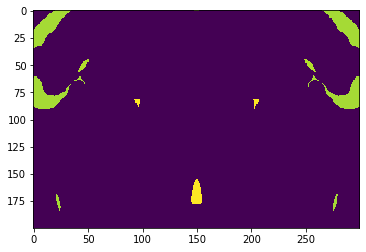

In [45]:
f = plt.figure()
a = f.add_subplot(1,1,1)
a.imshow(region_boundaries_array[340,100:300,(285-150):(285+150)])

In [69]:
z = region_boundaries_array[345,100:300,(285-150):(285+150)]

In [70]:
u, uu = np.unique(z, return_inverse=True)

In [71]:
zz = np.reshape(uu,(200,300))

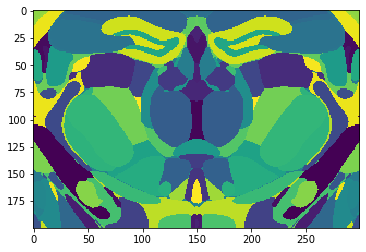

In [72]:
f = plt.figure()
a = f.add_subplot(1,1,1)
a.imshow(zz)

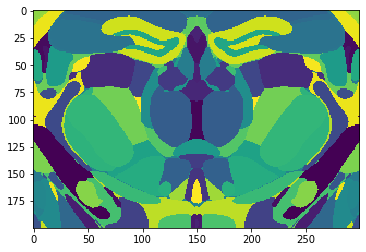

In [80]:
z = region_boundaries_array[345,100:300,(285-150):(285+150)]
u, uu = np.unique(z, return_inverse=True)
zz = np.reshape(uu,(200,300))

f = plt.figure()
a = f.add_subplot(1,1,1)
a.imshow(zz)

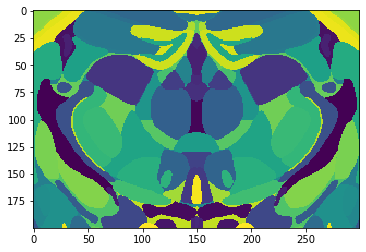

In [81]:
p = region_boundaries_array[330,100:300,(285-150):(285+150)]
q, qq = np.unique(p, return_inverse=True)
pp = np.reshape(qq,(200,300))

f = plt.figure()
a = f.add_subplot(1,1,1)
a.imshow(pp)

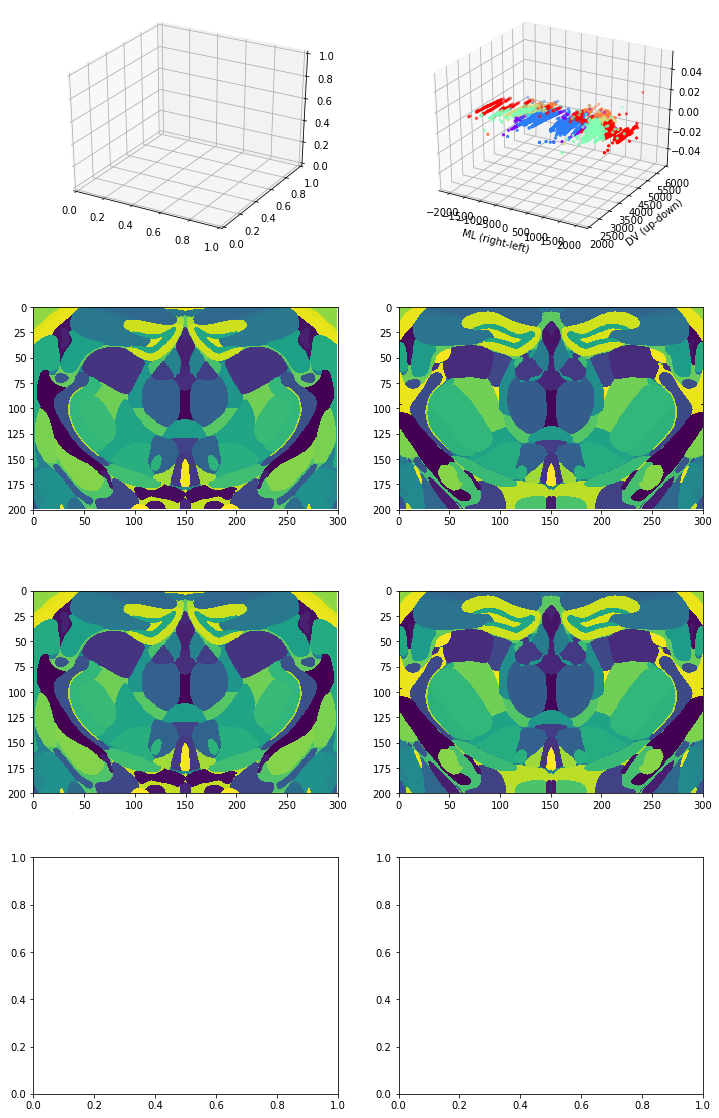

In [82]:
f = plt.figure(figsize=(12,20))

plot_dict = dict()
plot_dict['xlim'] = (-2500, 2500)
plot_dict['ylim'] = (1500,6500)
plot_dict['zlim'] = (0,2500)
plot_dict['axis_zero_label'] = 'ML'
plot_dict['axis_one_label'] = 'DV'
plot_dict['axis_two_label'] = 'AP'

clim_vals = (0,0.15)

a = f.add_subplot(4,2,1, projection='3d')

aa = f.add_subplot(4,2,2, projection='3d')

cc = ccf_analysis_utils.add_rainbow_plot(aa, use_subregion_list, thalamus_mat, r2, coords, \
                       r2_mask_thresh, three_d_flag, plot_dict)

thalamus_group_one_color_list = list()
for idx in thalamus_group_one_list_as_index:
    thalamus_group_one_color_list.append(cc[idx])

thalamus_group_two_color_list = list()
for idx in thalamus_group_two_list_as_index:
    thalamus_group_two_color_list.append(cc[idx]) 

three_d_flag = False

ax_zero = f.add_subplot(4,2,3)
ax_zero.imshow(pp)
ax_zero.set_xlim(0,300)
ax_zero.set_ylim(200,0)

ax_one = f.add_subplot(4,2,4)
ax_one.imshow(zz)
ax_one.set_xlim(0,300)
ax_one.set_ylim(200,0)

ax_zero = f.add_subplot(4,2,5)
ax_zero.imshow(pp)
ax_zero.set_xlim(0,300)
ax_zero.set_ylim(200,0)

ax_one = f.add_subplot(4,2,6)
ax_one.imshow(zz)
ax_one.set_xlim(0,300)
ax_one.set_ylim(200,0)

ax_bar = f.add_subplot(4,2,7)

ax_cdf = f.add_subplot(4,2,8)


f.savefig('./TempFigures/overlay_of_subregion_boundary_new.pdf',format='pdf')

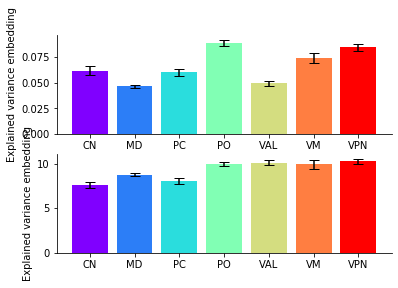

In [52]:
f = plt.figure()
ax_bar = f.add_subplot(2,1,1)

m = np.zeros(len(use_subregion_list))
sem = np.zeros(len(use_subregion_list))
for idx, sub_region_label in enumerate(use_subregion_list):
    m[idx] = np.mean(r2[thalamus_mat[use_subregion_list[idx]]])
    sem[idx] = np.std(r2[thalamus_mat[use_subregion_list[idx]]]) \
        /np.sqrt(r2[thalamus_mat[use_subregion_list[idx]]].shape[0])

ax_bar.bar(np.arange(0,len(use_subregion_list)),m, color = cc, \
           yerr=sem, align='center', ecolor='black', capsize=5)
_ = ax_bar.set_xticks(np.arange(0,len(use_subregion_list)))
_ = ax_bar.set_xticklabels(use_subregion_list)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
_ = ax_bar.set_ylabel('Explained variance embedding')

ax_bar = f.add_subplot(2,1,2)

m_fr = np.zeros(len(use_subregion_list))
sem = np.zeros(len(use_subregion_list))
for idx, sub_region_label in enumerate(use_subregion_list):
    m_fr[idx] = np.mean(mat['fr'][thalamus_mat[use_subregion_list[idx]]])
    sem[idx] = np.std(mat['fr'][thalamus_mat[use_subregion_list[idx]]]) \
        /np.sqrt(mat['fr'][thalamus_mat[use_subregion_list[idx]]].shape[0])

ax_bar.bar(np.arange(0,len(use_subregion_list)),m_fr, color = cc, \
           yerr=sem, align='center', ecolor='black', capsize=5)
_ = ax_bar.set_xticks(np.arange(0,len(use_subregion_list)))
_ = ax_bar.set_xticklabels(use_subregion_list)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
_ = ax_bar.set_ylabel('Explained variance embedding')

In [55]:
m[3]

0.08876147670985098

In [56]:
m_fr[3]

10.040216629511272

In [58]:
m_fr[4]

10.16912913424753

In [61]:
print(m*100)

[6.19961782 4.67835427 6.02613484 8.87614767 4.94874119 7.39676191
 8.4551378 ]


In [62]:
print(m_fr)

[ 7.58731234  8.81118841  8.09425512 10.04021663 10.16912913  9.96052683
 10.32229721]


(200.0, 0.0)

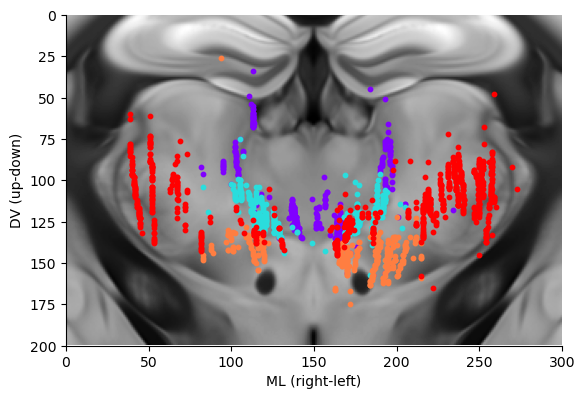

In [250]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.imshow(coronal_slices_array[340,100:300,(285-150):(285+150)],cmap='gray')
ccf_analysis_utils.add_solid_color_plot(ax, thalamus_group_one_list, thalamus_mat, r2, \
                     mapped_coords[:,0:2], r2_mask_thresh, thalamus_group_one_color_list, three_d_flag)
ax.set_xlim(0,300)
ax.set_ylim(200,0)

(200.0, 0.0)

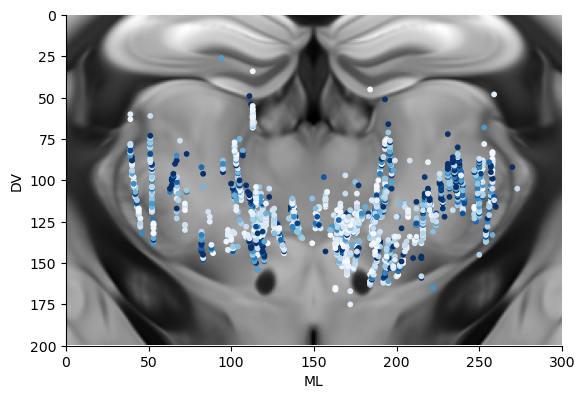

In [252]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.imshow(coronal_slices_array[340,100:300,(285-150):(285+150)],cmap='gray')
ccf_analysis_utils.add_color_map_plot(ax, thalamus_group_one_list, thalamus_mat, r2, \
                     mapped_coords[:,0:2], r2_mask_thresh, clim_vals, three_d_flag, plot_dict)
ax.set_xlim(0,300)
ax.set_ylim(200,0)

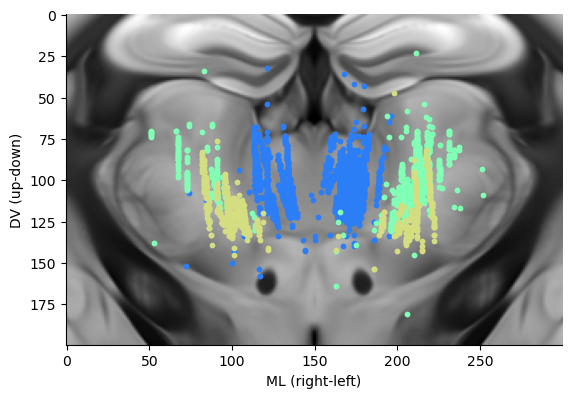

In [219]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.imshow(coronal_slices_array[340,100:300,(285-150):(285+150)],cmap='gray')
ccf_analysis_utils.add_solid_color_plot(ax, thalamus_group_two_list, thalamus_mat, r2, \
                     mapped_coords[:,0:2], r2_mask_thresh, thalamus_group_two_color_list, three_d_flag)

(200.0, 0.0)

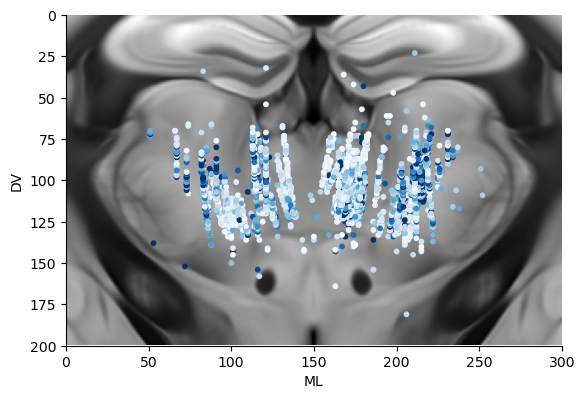

In [253]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.imshow(coronal_slices_array[340,100:300,(285-150):(285+150)],cmap='gray')
ccf_analysis_utils.add_color_map_plot(ax, thalamus_group_two_list, thalamus_mat, r2, \
                     mapped_coords[:,0:2], r2_mask_thresh, clim_vals, three_d_flag, plot_dict)
ax.set_xlim(0,300)
ax.set_ylim(200,0)

I have 5000 in each axis so I need 250 pixels
Actually no I am taking DV from 2000 to 6000

In [83]:
275*20

5500

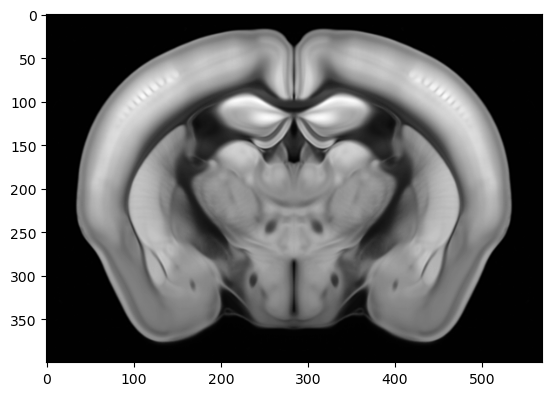

In [129]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.imshow(coronal_slices_array[320,:,:],cmap='gray')

In [51]:
coronal_slices_array.shape

(660, 400, 570)

In [60]:
570/2

285.0

In [36]:
#load xlsx file
import pandas as pd

df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
df.head()

,id,region,tree
0,997,root,/997/
1,8,Basic cell groups and regions,/997/8/
2,567,Cerebrum,/997/8/567/
3,688,Cerebral cortex,/997/8/567/688/
4,695,Cortical plate,/997/8/567/688/695/


In [ ]:
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)


In [44]:
Thalamus_tree = df[df['region'] == 'Thalamus']['tree'].values[0]

In [49]:
tree = df['tree'].values
#thalamus_subregion_trees = df['tree'].str.contains(Thalamus_tree)

#print(thalamus_subregions)

df[df['tree'].str.contains(Thalamus_tree)]

,id,region,tree
569,549,Thalamus,/997/8/343/1129/549/
570,864,Thalamus/sensory-motor cortex related,/997/8/343/1129/549/864/
571,637,Ventral group of the dorsal thalamus,/997/8/343/1129/549/864/637/
572,629,Ventral anterior-lateral complex of the thalamus,/997/8/343/1129/549/864/637/629/
573,685,Ventral medial nucleus of the thalamus,/997/8/343/1129/549/864/637/685/
...,...,...,...
629,321,Subgeniculate nucleus,/997/8/343/1129/549/856/1014/321/
630,958,Epithalamus,/997/8/343/1129/549/856/958/
631,483,Medial habenula,/997/8/343/1129/549/856/958/483/
632,186,Lateral habenula,/997/8/343/1129/549/856/958/186/


In [68]:
one_layer_down_from_thalamus = df[df['tree'].str.contains(Thalamus_tree) & (df['tree'].str.count('/') == (Thalamus_tree.count('/')+1))]
one_layer_down_from_thalamus

,id,region,tree
570,864,Thalamus/sensory-motor cortex related,/997/8/343/1129/549/864/
590,856,Thalamus/polymodal association cortex related,/997/8/343/1129/549/856/


In [69]:
two_layer_down_from_thalamus = df[df['tree'].str.contains(Thalamus_tree) & (df['tree'].str.count('/') == (Thalamus_tree.count('/')+2))]
two_layer_down_from_thalamus

,id,region,tree
571,637,Ventral group of the dorsal thalamus,/997/8/343/1129/549/864/637/
579,406,Subparafascicular nucleus,/997/8/343/1129/549/864/406/
582,609,Subparafascicular area,/997/8/343/1129/549/864/609/
583,1044,Peripeduncular nucleus,/997/8/343/1129/549/864/1044/
584,1008,Geniculate group/dorsal thalamus,/997/8/343/1129/549/864/1008/
591,138,Lateral group of the dorsal thalamus,/997/8/343/1129/549/856/138/
596,239,Anterior group of the dorsal thalamus,/997/8/343/1129/549/856/239/
605,444,Medial group of the dorsal thalamus,/997/8/343/1129/549/856/444/
613,571,Midline group of the dorsal thalamus,/997/8/343/1129/549/856/571/
617,51,Intralaminar nuclei of the dorsal thalamus,/997/8/343/1129/549/856/51/


In [70]:
def get_region_tree(df, name):
    return df[df['region'] == name]['tree'].values[0]

def get_all_subregion_annotations_from_tree(df, tree):
    return df[df['tree'].str.contains(tree)]
              
def get_all_subregion_annotations_from_name(df, name):
    tree = get_region_tree(df, name)
    return get_all_subregion_annotations_from_tree(df, tree)

def get_n_layer_down_subregions_from_tree(df, tree, n):
    return df[df['tree'].str.contains(tree) & (df['tree'].str.count('/') == (tree.count('/')+n))]

def get_n_layer_down_subregions_from_name(df, name, n):
    tree = get_region_tree(df, name)
    return get_n_layer_down_subregions_from_tree(df, tree, n)


In [71]:
get_all_subregion_annotations_from_name(df, 'Midbrain')

,id,region,tree
719,313,Midbrain,/997/8/343/313/
720,339,Midbrain/sensory related,/997/8/343/313/339/
721,302,Superior colliculus/sensory related,/997/8/343/313/339/302/
722,851,Superior colliculus/optic layer,/997/8/343/313/339/302/851/
723,842,Superior colliculus/superficial gray layer,/997/8/343/313/339/302/842/
...,...,...,...
775,12,Interfascicular nucleus raphe,/997/8/343/313/348/165/12/
776,100,Interpeduncular nucleus,/997/8/343/313/348/165/100/
777,197,Rostral linear nucleus raphe,/997/8/343/313/348/165/197/
778,591,Central linear nucleus raphe,/997/8/343/313/348/165/591/


In [72]:
get_n_layer_down_subregions_from_name(df, 'Midbrain', 1)

,id,region,tree
720,339,Midbrain/sensory related,/997/8/343/313/339/
733,323,Midbrain/motor related,/997/8/343/313/323/
771,348,Midbrain/behavioral state related,/997/8/343/313/348/


In [73]:
get_all_subregion_annotations_from_name(df, 'Striatum')

,id,region,tree
500,477,Striatum,/997/8/567/623/477/
501,485,Striatum dorsal region,/997/8/567/623/477/485/
502,672,Caudoputamen,/997/8/567/623/477/485/672/
503,493,Striatum ventral region,/997/8/567/623/477/493/
504,56,Nucleus accumbens,/997/8/567/623/477/493/56/
505,998,Fundus of striatum,/997/8/567/623/477/493/998/
506,754,Olfactory tubercle,/997/8/567/623/477/493/754/
507,481,Islands of Calleja,/997/8/567/623/477/493/754/481/
508,489,Major island of Calleja,/997/8/567/623/477/493/754/489/
509,144,Olfactory tubercle/layers 1-3,/997/8/567/623/477/493/754/144/


In [75]:
thalamus_subregions_annotation_dict = dict()

thalamus_sub_df = get_n_layer_down_subregions_from_name(df, 'Thalamus', 2)

for subreg in thalamus_sub_df['region']:
    thalamus_subregions_annotation_dict[subreg] = get_all_subregion_annotations_from_name(df, subreg)['region'].values

print(thalamus_subregions_annotation_dict)

{'Ventral group of the dorsal thalamus': array(['Ventral group of the dorsal thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral posterior complex of the thalamus',
       'Ventral posterolateral nucleus of the thalamus',
       'Ventral posterolateral nucleus of the thalamus/parvicellular part',
       'Ventral posteromedial nucleus of the thalamus',
       'Ventral posteromedial nucleus of the thalamus/parvicellular part'],
      dtype=object), 'Subparafascicular nucleus': array(['Subparafascicular nucleus',
       'Subparafascicular nucleus/magnocellular part',
       'Subparafascicular nucleus/parvicellular part'], dtype=object), 'Subparafascicular area': array(['Subparafascicular area'], dtype=object), 'Peripeduncular nucleus': array(['Peripeduncular nucleus'], dtype=object), 'Geniculate group/dorsal thalamus': array(['Geniculate group/dorsal thalamus', 'Medial geniculate complex',
       'Medial ge

In [80]:
def sum_up_neurons(annotations_list, subregion_annotations):
    n = 0
    for subreg in subregion_annotations:
        n += np.sum(annotations_list == subreg)
    return n

neuron_count = dict()

for subreg, subreg_annots in thalamus_subregions_annotation_dict.items():
    neuron_count[subreg] = sum_up_neurons(mat['annotation'], subreg_annots)

n = 0
for k,v in neuron_count.items():
    print(k,v)
    n+=v

print(n)

Ventral group of the dorsal thalamus 1622
Subparafascicular nucleus 0
Subparafascicular area 22
Peripeduncular nucleus 0
Geniculate group/dorsal thalamus 0
Lateral group of the dorsal thalamus 1523
Anterior group of the dorsal thalamus 574
Medial group of the dorsal thalamus 1993
Midline group of the dorsal thalamus 32
Intralaminar nuclei of the dorsal thalamus 1001
Reticular nucleus of the thalamus 76
Geniculate group/ventral thalamus 0
Epithalamus 190
7033


In [79]:
n= 0
for k,v in thalamus_mat.items():
    if k in subregion_list:
        print(k,v.shape)
        n += v.shape[0]
print(n)

AN (197,)
CN (382,)
MD (1709,)
MGN (126,)
PC (400,)
PF (169,)
PO (901,)
PVN (32,)
RT (76,)
SMN (154,)
VAL (667,)
VM (328,)
VPN (821,)
5962


No agreement, because the Thalamus nuclei were picked in a much more complicated way.